In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from numba import jit,f8,prange,i8

from sklearn.linear_model import Lasso,ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


%matplotlib inline

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

log(価格)が正規分布じゃあないのが効いてるのでは？？という観点にしか今回は興味がないので、  
説明変数は数値ならintだろうがfloatだろうが標準化、カテゴリ変数はOne-Hot Encodingしたのち標準化という感じの雑前処理で比較していく

In [3]:
y_raw = train['SalePrice']
train = train.set_index('Id').drop('SalePrice',axis=1)
test = test.set_index('Id')
M = len(y_raw)

In [4]:

obj_obj = train.dtypes[train.dtypes == object]

In [5]:

columns_obj =  obj_obj.to_dict().keys()

In [6]:
train_dropped = train.drop(columns_obj,axis=1)
train_dropped = train_dropped.fillna(train_dropped.median())
test_dropped = test.drop(columns_obj,axis=1)
test_dropped = test_dropped.fillna(test_dropped.median())

In [7]:
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)
ohe.fit(train[columns_obj])
X_train_cat = ohe.transform(train[columns_obj])
X_test_cat = ohe.transform(test[columns_obj])

In [8]:
X_train = np.c_[train_dropped.values,X_train_cat]
X_test = np.c_[test_dropped.values,X_test_cat]

In [9]:
scaler = StandardScaler()

In [10]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
N = X_train[0].size

In [12]:
X_test[0].size

304

In [13]:
y_train = np.log(y_raw.values)
y_mean = y_train.mean()
y_train = y_train - y_mean

In [14]:
N_grid_search = 10
alpha_array = np.logspace(-3,-1,N_grid_search)
l1_ratio_array = np.linspace(1e-2,0.99,N_grid_search)

In [15]:
kf = KFold(10,shuffle=True,random_state=42)

比較のために二乗損失の場合を見る。マルチコがあるからとりあえずElasticNetでやってみる。  
評価はMAE、損失関数と違うもので評価してパラメータを採用するのは嫌なんだけども(何やってるのかよくわからなくなるので)、本命と比較するため。  
※追記
よくよく考えればMAEとMSEの両方をみてrefitとMSEにすればよかった

In [16]:
en = ElasticNet(warm_start=True,fit_intercept=False)
parameters = {'alpha':alpha_array, 'l1_ratio':l1_ratio_array}
clf = GridSearchCV(en, parameters,cv=kf,scoring='neg_mean_absolute_error',n_jobs=-1)
clf.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=ElasticNet(fit_intercept=False, warm_start=True),
             n_jobs=-1,
             param_grid={'alpha': array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ]),
                         'l1_ratio': array([0.01      , 0.11888889, 0.22777778, 0.33666667, 0.44555556,
       0.55444444, 0.66333333, 0.77222222, 0.88111111, 0.99      ])},
             scoring='neg_mean_absolute_error')

In [17]:
df_result = pd.DataFrame.from_dict(clf.cv_results_)
df_result[df_result['mean_test_score']==df_result['mean_test_score'].max()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
36,0.083502,0.014223,0.001331,0.000612,0.00464159,0.663333,"{'alpha': 0.004641588833612777, 'l1_ratio': 0....",-0.075418,-0.090913,-0.072304,-0.081976,-0.086316,-0.101202,-0.090662,-0.073466,-0.078855,-0.064833,-0.081594,0.010271,1


In [18]:
best_en = clf.best_estimator_

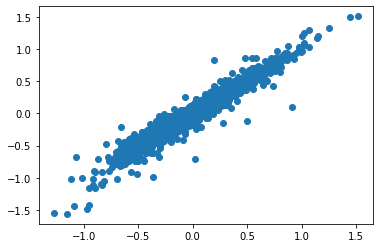

In [19]:
plt.plot(best_en.predict(X_train),y_train,"o")

In [20]:
y_pred_en = np.exp(best_en.predict(X_test)+y_mean)

In [21]:
# データの整形
submitPre = pd.DataFrame({
                        'Id':list(test.index),
                        'SalePrice':y_pred_en
                        })
# CSV出力
submitPre.to_csv("sub_en.csv",index=False)

よくよく考えれば訓練とテストの分布が同じだと思っているわけで、そうするとマルチコは予測には関係ないのでLassoでええやんとなった。

In [22]:
lasso = Lasso(warm_start=True,fit_intercept=False)
parameters = {'alpha':alpha_array}
clf = GridSearchCV(lasso, parameters,cv=kf,scoring='neg_mean_absolute_error',n_jobs=-1)
clf.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Lasso(fit_intercept=False, warm_start=True), n_jobs=-1,
             param_grid={'alpha': array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ])},
             scoring='neg_mean_absolute_error')

In [23]:
df_result = pd.DataFrame.from_dict(clf.cv_results_)
df_result[df_result['mean_test_score']==df_result['mean_test_score'].max()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
2,0.053359,0.006244,0.001965,0.002216,0.00278256,{'alpha': 0.0027825594022071257},-0.075533,-0.090683,-0.072302,-0.081519,-0.086472,-0.101106,-0.09092,-0.073768,-0.078897,-0.064814,-0.081601,0.010234,1


In [24]:
best_lasso = clf.best_estimator_

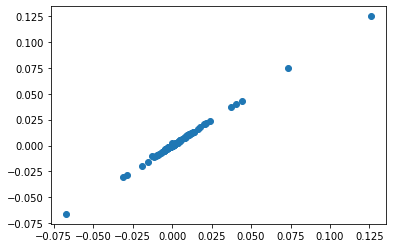

In [25]:
plt.plot(best_lasso.coef_,best_en.coef_,"o")

In [26]:
y_pred_lasso = np.exp(best_lasso.predict(X_test)+y_mean)

In [27]:
# データの整形
submitPre = pd.DataFrame({
                        'Id':list(test.index),
                        'SalePrice':y_pred_lasso
                        })
# CSV出力
submitPre.to_csv("sub_lasso.csv",index=False)

ElasticNet:MAE -0.081594　±　0.010271  
Lasso:MAE -0.081601　±　0.010234  
やはりほぼ変わらない。

固有値を見てみる。

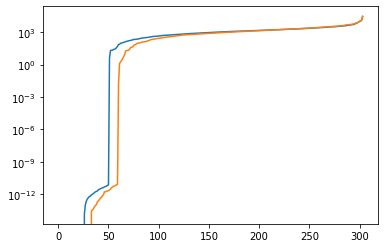

In [28]:
plt.semilogy(np.linalg.eigvalsh(X_train.T@X_train))
plt.semilogy(np.linalg.eigvalsh(X_test.T@X_test))

楽なのでまずLeast absolute deviations(LAD)+L1正則化    

In [29]:
@jit('f8[:](f8[:],f8)',nopython=True)
def soft_thresholding(x,l):
    return np.sign(x)*np.maximum(np.abs(x)-l,0)

In [30]:
@jit('f8[:](f8[:,:],f8[:],f8,f8,f8,i8,f8)',nopython=True,fastmath=True)
def lad_l1_admm(X,y,lam,rho1,rho2,max_iter,tol):
    N = X[0].size
    M = y.size
    I_M = np.eye(M)
    I_N = np.eye(N)
    
    ## \beta - w = 0
    beta = np.zeros(N)
    w = np.zeros(N)
    v = np.zeros(N)
    
    ## X\beta-y=z
    z = np.zeros(M)
    u = np.zeros(M)
    
    
    X = np.asfortranarray(X)
    y = np.asfortranarray(y)
    XTX_inv = np.linalg.inv(np.dot(X.T,X)+rho1/rho2*I_N)
    for i in range(max_iter):
        beta= XTX_inv.dot(X.T.dot(y+z-u)+rho1/rho2*(w-v))
        
        w_prev = w.copy()
        w = soft_thresholding(beta+v,lam/rho2)
        v = v + beta - w
        
        z = soft_thresholding(X.dot(beta)-y+u,1/rho1)
        u = u + X.dot(beta)- z -y
 
        if np.sum(np.abs(w_prev-w))<tol:
            return w
    return w

In [31]:
class LadL1ADMM(BaseEstimator, RegressorMixin):
    def __init__(self,lam=0.01,rho1=1.,rho2=1.,max_iter=100,tol=1e-3):
        self.lam = lam
        self.rho1 = rho1
        self.rho2 = rho2
        self.max_iter = max_iter
        self.tol = tol
        
    def fit(self,X,y):
        self.coef_ = lad_l1_admm(X,y,self.lam,self.rho1,self.rho2,self.max_iter,self.tol)
        return self
        
    def predict(self,X):
        return X.dot(self.coef_)  

適当なパラメータで試してみる.

In [32]:
ladl1 = LadL1ADMM(lam=0.06)
ladl1.fit(X_train,y_train)

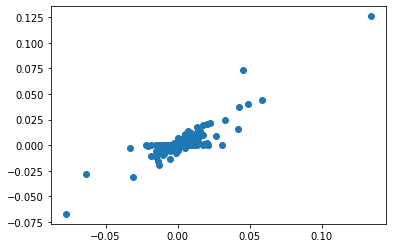

In [34]:
plt.plot(ladl1.coef_,best_lasso.coef_,"o")

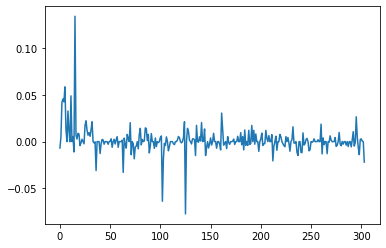

In [35]:
plt.plot(ladl1.coef_)

In [36]:
np.abs(y_train-X_train@ladl1.coef_).sum()/M

0.06123431952355995

In [37]:
np.abs(y_train-X_train@best_en.coef_).sum()/M

0.0706301867785588

lam(Lassoだとalpha)はちょっと適当なパラメータで何度か動かしたときに比較的小さい値でも全0を返したのでちょっと探索範囲を狭めている。  
ちょっとズルい。

In [71]:
lam_array = np.logspace(-3,-0.8,N_grid_search)
rho1_array = np.logspace(-3,2,N_grid_search)
rho2_array = np.logspace(-3,2,N_grid_search)

In [72]:
ladl1 = LadL1ADMM(max_iter=100)
parameters = {'lam':lam_array,'rho1':rho1_array,'rho2':rho2_array}
clf = GridSearchCV(ladl1, parameters,cv=kf,scoring='neg_mean_absolute_error',n_jobs=-1)
clf.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=LadL1ADMM(), n_jobs=-1,
             param_grid={'lam': array([0.001     , 0.00175568, 0.0030824 , 0.0054117 , 0.00950119,
       0.01668101, 0.02928645, 0.05141752, 0.09027252, 0.15848932]),
                         'rho1': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                         'rho2': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02])},
             scoring='neg_mean_absolute_error')

In [73]:
df_result = pd.DataFrame.from_dict(clf.cv_results_)
df_result[df_result['mean_test_score']==df_result['mean_test_score'].max()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lam,param_rho1,param_rho2,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
184,0.1415,0.022953,0.001025,0.000316,0.00175568,27.8256,0.16681,"{'lam': 0.0017556762912750014, 'rho1': 27.8255...",-0.072858,-0.095564,...,-0.080951,-0.086104,-0.09879,-0.086143,-0.07264,-0.07837,-0.065484,-0.080725,0.010381,1


-0.080725 ± 0.010381
まあ1標準偏差内ではあるが一応改善されているっぽい  
  
下を見ると結構スパースな係数をちゃんと出していて、選んでいるパラメータも違うっぽい

In [74]:
best_ladl1 = clf.best_estimator_

In [75]:
best_ladl1.get_params()

{'lam': 0.0017556762912750014,
 'max_iter': 100,
 'rho1': 27.825594022071257,
 'rho2': 0.1668100537200059,
 'tol': 0.001}

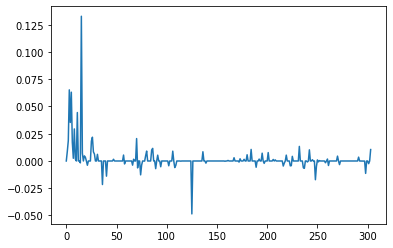

In [76]:
plt.plot(best_ladl1.coef_)

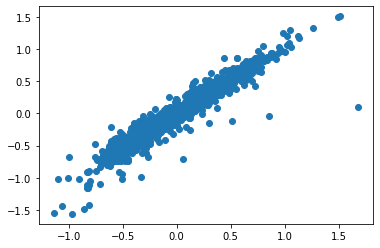

In [77]:
plt.plot(best_ladl1.predict(X_train),y_train,"o")

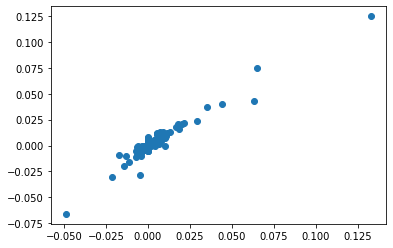

In [78]:
plt.plot(best_ladl1.coef_,best_en.coef_,"o")

In [79]:
y_pred_ladl1 = np.exp(best_ladl1.predict(X_test)+y_mean)

In [80]:
# データの整形
submitPre = pd.DataFrame({
                        'Id':list(test.index),
                        'SalePrice':y_pred_ladl1
                        })
# CSV出力
submitPre.to_csv("sub_lad.csv",index=False)

In [61]:
%%timeit
beta_lad = lad_l1_admm(X_train,y_train,3e-2,1e-1,1,200,1e-3)

25.8 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


LassoとElasticNetではふつうあのくらいだと差はないと思うが、  
soft-thresholdingの中身をちょっと変えるだけでElasticNetペナルティになるのでやってみた

In [82]:
@jit('f8[:](f8[:,:],f8[:],f8,f8,f8,f8,i8,f8)',nopython=True,fastmath=True)
def lad_en_admm(X,y,lam1,lam2,rho1,rho2,max_iter,tol):
    N = X[0].size
    M = y.size
    I_M = np.eye(M)
    I_N = np.eye(N)
    
    ## \beta - w = 0
    beta = np.zeros(N)
    w = np.zeros(N)
    v = np.zeros(N)
    
    ## X\beta-y=z
    z = np.zeros(M)
    u = np.zeros(M)
    
    
    X = np.asfortranarray(X)
    y = np.asfortranarray(y)
    XTX_inv = np.linalg.inv(np.dot(X.T,X)+rho1/rho2*I_N)
    for i in range(max_iter):
        beta= XTX_inv.dot(X.T.dot(y+z-u)+rho1/rho2*(w-v))
        
        w_prev = w.copy()
        w = soft_thresholding(rho2/(rho2+2*lam2)*(beta+v),lam1/2)
        v = v + beta - w
        
        z = soft_thresholding(X.dot(beta)-y+u,1/rho1)
        u = u + X.dot(beta)- z -y
 
        if np.sum(np.abs(w_prev-w))<tol:
            return w
    return (1+lam2)*w

In [83]:
class LadENADMM(BaseEstimator, RegressorMixin):
    def __init__(self,lam1=0.01,lam2=0.01,rho1=1.,rho2=1.,max_iter=100,tol=1e-3):
        self.lam1 = lam1
        self.lam2 = lam2
        self.rho1 = rho1
        self.rho2 = rho2
        self.max_iter = max_iter
        self.tol = tol
        
    def fit(self,X,y):
        self.coef_ = lad_en_admm(X,y,self.lam1,self.lam2,self.rho1,self.rho2,self.max_iter,self.tol)
        return self
        
    def predict(self,X):
        return X.dot(self.coef_)  

In [88]:
laden = LadENADMM(lam1=0.06,lam2=0.01)
laden.fit(X_train,y_train)

LadENADMM(lam1=0.06)

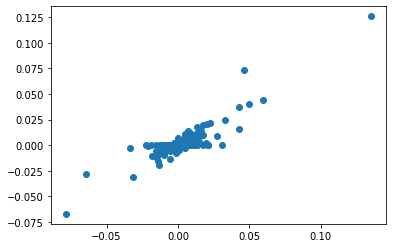

In [89]:
plt.plot(laden.coef_,best_lasso.coef_,"o")

In [90]:
np.abs(y_train-X_train@laden.coef_).sum()/M

0.06115495737592796

一回のfitが30 msくらいなので気長に待てばL1のときと同じようにrho2も回しても別にいい気もするが,  
基本的に比としてしか効いていないのでrho2=1で固定しても問題ない。

In [100]:
lam1_array = np.logspace(-3,-0.8,N_grid_search)
lam2_array = np.logspace(-3,-0.8,N_grid_search)
rho1_array = np.logspace(-1,3,N_grid_search)

In [101]:
laden = LadENADMM(max_iter=100)
parameters = {'lam1':lam1_array,'lam2':lam2_array,'rho1':rho1_array}
clf = GridSearchCV(laden, parameters,cv=kf,scoring='neg_mean_absolute_error',n_jobs=-1)
clf.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=LadENADMM(), n_jobs=-1,
             param_grid={'lam1': array([0.001     , 0.00175568, 0.0030824 , 0.0054117 , 0.00950119,
       0.01668101, 0.02928645, 0.05141752, 0.09027252, 0.15848932]),
                         'lam2': array([0.001     , 0.00175568, 0.0030824 , 0.0054117 , 0.00950119,
       0.01668101, 0.02928645, 0.05141752, 0.09027252, 0.15848932]),
                         'rho1': array([1.00000000e-01, 2.78255940e-01, 7.74263683e-01, 2.15443469e+00,
       5.99484250e+00, 1.66810054e+01, 4.64158883e+01, 1.29154967e+02,
       3.59381366e+02, 1.00000000e+03])},
             scoring='neg_mean_absolute_error')

In [103]:
df_result = pd.DataFrame.from_dict(clf.cv_results_)
df_result[df_result['mean_test_score']==df_result['mean_test_score'].max()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lam1,param_lam2,param_rho1,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
766,0.131206,0.013806,0.0011,0.000472,0.0514175,0.0292864,46.4159,"{'lam1': 0.051417518276839276, 'lam2': 0.02928...",-0.072035,-0.094739,...,-0.080081,-0.085747,-0.098167,-0.086762,-0.074019,-0.078568,-0.063789,-0.080541,0.010292,1


LADの場合:  
ElasticNetペナルティ: -0.080541±0.010292  
L1:-0.080725 ± 0.010381  

In [104]:
best_laden = clf.best_estimator_

In [105]:
best_laden.get_params()

{'lam1': 0.051417518276839276,
 'lam2': 0.029286445646252372,
 'max_iter': 100,
 'rho1': 46.41588833612777,
 'rho2': 1.0,
 'tol': 0.001}

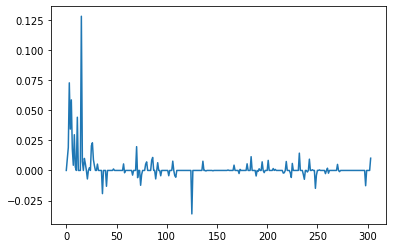

In [106]:
plt.plot(best_laden.coef_)

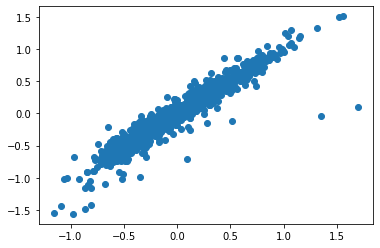

In [107]:
plt.plot(best_laden.predict(X_train),y_train,"o")

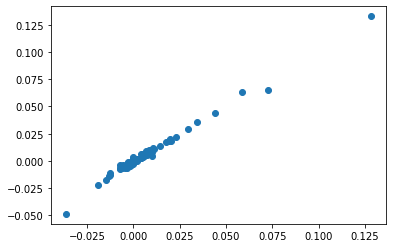

In [109]:
plt.plot(best_laden.coef_,best_ladl1.coef_,"o")

In [110]:
y_pred_laden = np.exp(best_laden.predict(X_test)+y_mean)

In [111]:
# データの整形
submitPre = pd.DataFrame({
                        'Id':list(test.index),
                        'SalePrice':y_pred_laden
                        })
# CSV出力
submitPre.to_csv("sub_laden.csv",index=False)

In [112]:
@jit('f8[:](f8[:,:],f8[:],f8,f8,f8,f8,f8,i8,f8)',nopython=True,fastmath=True)
def huber_en_admm(X,y,lam1,lam2,delta,rho1,rho2,max_iter,tol):
    N = X[0].size
    M = y.size
    I_M = np.eye(M)
    I_N = np.eye(N)
    
    ## \beta - w = 0
    beta = np.zeros(N)
    w = np.zeros(N)
    v = np.zeros(N)
    
    ## X\beta-y=z
    z = np.zeros(M)
    u = np.zeros(M)
    
    
    X = np.asfortranarray(X)
    y = np.asfortranarray(y)
    XTX_inv = np.linalg.inv(np.dot(X.T,X)+rho1/rho2*I_N)
    for i in range(max_iter):
        beta= XTX_inv.dot(X.T.dot(y+z-u)+rho1/rho2*(w-v))
        
        w_prev = w.copy()
        w = soft_thresholding(rho2/(rho2+2*lam2)*(beta+v),lam1/2)
        v = v + beta - w
        
        z_tmp = X.dot(beta)-y+u
        z = (rho1/(rho1+delta))*z_tmp + 1/(rho1+delta)*soft_thresholding(z_tmp,1+delta/rho1)
        u = u + X.dot(beta)- z -y
 
        if np.sum(np.abs(w_prev-w))<tol:
            return w
    return (1+lam2)*w

In [115]:
class HuberENADMM(BaseEstimator, RegressorMixin):
    def __init__(self,lam1=0.01,lam2=0.01,delta=1,rho1=1.,rho2=1.,max_iter=100,tol=1e-3):
        self.lam1 = lam1
        self.lam2 = lam2
        self.delta = delta
        self.rho1 = rho1
        self.rho2 = rho2
        self.max_iter = max_iter
        self.tol = tol
        
    def fit(self,X,y):
        self.coef_ = huber_en_admm(X,y,self.lam1,self.lam2,self.delta,self.rho1,self.rho2,self.max_iter,self.tol)
        return self
        
    def predict(self,X):
        return X.dot(self.coef_)  

In [116]:
huberen = HuberENADMM(lam1=0.06,lam2=0.01)
huberen.fit(X_train,y_train)

HuberENADMM(lam1=0.06)

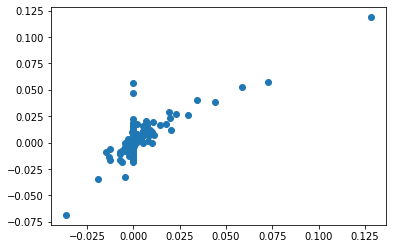

In [117]:
plt.plot(best_laden.coef_,huberen.coef_,"o")

In [118]:
np.abs(y_train-X_train@huberen.coef_).sum()/M

0.06540114897531953

In [146]:
lam1_array = np.logspace(-3,-0.8,N_grid_search)
lam2_array = np.logspace(-6,-2,N_grid_search)
rho1_array = np.logspace(0,3,N_grid_search)
delta_array = np.logspace(-2,-0.5,N_grid_search)

In [147]:
huberen = HuberENADMM(max_iter=100)
parameters = {'lam1':lam1_array,'lam2':lam2_array,'delta':delta_array,'rho1':rho1_array}
clf = GridSearchCV(huberen, parameters,cv=kf,scoring='neg_mean_absolute_error',n_jobs=-1)
clf.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=HuberENADMM(), n_jobs=-1,
             param_grid={'delta': array([0.01      , 0.01467799, 0.02154435, 0.03162278, 0.04641589,
       0.06812921, 0.1       , 0.14677993, 0.21544347, 0.31622777]),
                         'lam1': array([0.001     , 0.00175568, 0.0030824 , 0.0054117 , 0.00950119,
       0.01668101, 0.02928645, 0.05141752, 0.09027252, 0.15848932]),
                         'lam2': array([1.00000000e-06, 2.78255940e-06, 7.74263683e-06, 2.15443469e-05,
       5.99484250e-05, 1.66810054e-04, 4.64158883e-04, 1.29154967e-03,
       3.59381366e-03, 1.00000000e-02]),
                         'rho1': array([   1.        ,    2.15443469,    4.64158883,   10.        ,
         21.5443469 ,   46.41588834,  100.        ,  215.443469  ,
        464.15888336, 1000.        ])},
             scoring='neg_mean_absolute_error')

In [148]:
df_result = pd.DataFrame.from_dict(clf.cv_results_)
df_result[df_result['mean_test_score']==df_result['mean_test_score'].max()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_delta,param_lam1,param_lam2,param_rho1,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
8802,0.140158,0.011101,0.001149,0.000542,0.215443,0.0902725,1e-06,4.64159,"{'delta': 0.21544346900318834, 'lam1': 0.09027...",-0.075048,...,-0.08212,-0.086012,-0.101386,-0.090669,-0.072958,-0.078929,-0.064717,-0.081501,0.0104,1


LAD+ElasticNet  : -0.080541±0.010292  
Huber+ElasticNet:-0.081501 ± 0.01032  

In [149]:
best_huberen = clf.best_estimator_

In [150]:
best_huberen.get_params()

{'delta': 0.21544346900318834,
 'lam1': 0.09027251779484578,
 'lam2': 1e-06,
 'max_iter': 100,
 'rho1': 4.641588833612778,
 'rho2': 1.0,
 'tol': 0.001}

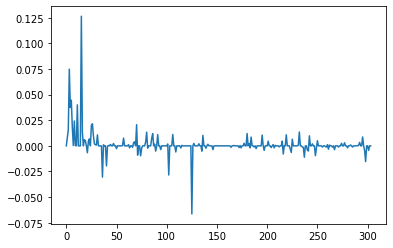

In [153]:
plt.plot(best_huberen.coef_)

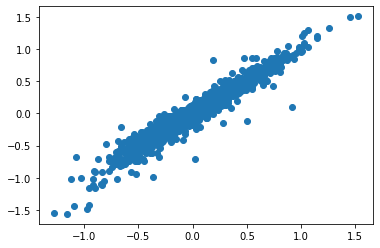

In [154]:
plt.plot(best_huberen.predict(X_train),y_train,"o")

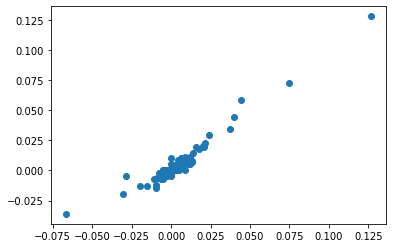

In [155]:
plt.plot(best_huberen.coef_,best_laden.coef_,"o")

In [156]:
y_pred_huberen = np.exp(best_huberen.predict(X_test)+y_mean)

In [157]:
# データの整形
submitPre = pd.DataFrame({
                        'Id':list(test.index),
                        'SalePrice':y_pred_huberen
                        })
# CSV出力
submitPre.to_csv("sub_huberen.csv",index=False)

In [159]:
@jit('f8[:](f8[:,:],f8[:],f8,f8,f8,f8,i8,f8)',nopython=True,fastmath=True)
def huber_l1_admm(X,y,lam,delta,rho1,rho2,max_iter,tol):
    N = X[0].size
    M = y.size
    I_M = np.eye(M)
    I_N = np.eye(N)
    
    ## \beta - w = 0
    beta = np.zeros(N)
    w = np.zeros(N)
    v = np.zeros(N)
    
    ## X\beta-y=z
    z = np.zeros(M)
    u = np.zeros(M)
    
    
    X = np.asfortranarray(X)
    y = np.asfortranarray(y)
    XTX_inv = np.linalg.inv(np.dot(X.T,X)+rho1/rho2*I_N)
    for i in range(max_iter):
        beta= XTX_inv.dot(X.T.dot(y+z-u)+rho1/rho2*(w-v))
        
        w_prev = w.copy()
        w = soft_thresholding(beta+v,lam/rho2)
        v = v + beta - w
        
        z_tmp = X.dot(beta)-y+u
        z = (rho1/(rho1+delta))*z_tmp + 1/(rho1+delta)*soft_thresholding(z_tmp,1+delta/rho1)
        u = u + X.dot(beta)- z -y
 
        if np.sum(np.abs(w_prev-w))<tol:
            return w
    return w

In [160]:
class HuberL1ADMM(BaseEstimator, RegressorMixin):
    def __init__(self,lam=0.01,delta=1,rho1=1.,rho2=1.,max_iter=100,tol=1e-3):
        self.lam = lam
        self.delta = delta
        self.rho1 = rho1
        self.rho2 = rho2
        self.max_iter = max_iter
        self.tol = tol
        
    def fit(self,X,y):
        self.coef_ = huber_l1_admm(X,y,self.lam,self.delta,self.rho1,self.rho2,self.max_iter,self.tol)
        return self
        
    def predict(self,X):
        return X.dot(self.coef_)  

In [161]:
lam_array = np.logspace(-3,-0.8,N_grid_search)
rho1_array = np.logspace(0,3,N_grid_search)
delta_array = np.logspace(-2,-0.5,N_grid_search)

In [163]:
huberl1 = HuberL1ADMM(max_iter=100)
parameters = {'lam':lam_array,'delta':delta_array,'rho1':rho1_array}
clf = GridSearchCV(huberl1, parameters,cv=kf,scoring='neg_mean_absolute_error',n_jobs=-1)
clf.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=HuberL1ADMM(), n_jobs=-1,
             param_grid={'delta': array([0.01      , 0.01467799, 0.02154435, 0.03162278, 0.04641589,
       0.06812921, 0.1       , 0.14677993, 0.21544347, 0.31622777]),
                         'lam': array([0.001     , 0.00175568, 0.0030824 , 0.0054117 , 0.00950119,
       0.01668101, 0.02928645, 0.05141752, 0.09027252, 0.15848932]),
                         'rho1': array([   1.        ,    2.15443469,    4.64158883,   10.        ,
         21.5443469 ,   46.41588834,  100.        ,  215.443469  ,
        464.15888336, 1000.        ])},
             scoring='neg_mean_absolute_error')

In [164]:
df_result = pd.DataFrame.from_dict(clf.cv_results_)
df_result[df_result['mean_test_score']==df_result['mean_test_score'].max()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_delta,param_lam,param_rho1,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
762,0.146356,0.007689,0.001122,0.000618,0.14678,0.0292864,4.64159,"{'delta': 0.1467799267622069, 'lam': 0.0292864...",-0.075283,-0.090813,...,-0.081829,-0.086144,-0.101162,-0.090757,-0.07325,-0.078872,-0.064813,-0.081512,0.010292,1


In [165]:
best_huberl1 = clf.best_estimator_

In [166]:
best_huberl1.get_params()

{'delta': 0.1467799267622069,
 'lam': 0.029286445646252372,
 'max_iter': 100,
 'rho1': 4.641588833612778,
 'rho2': 1.0,
 'tol': 0.001}

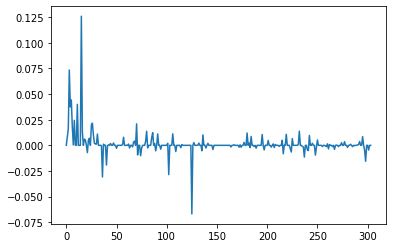

In [167]:
plt.plot(best_huberl1.coef_)

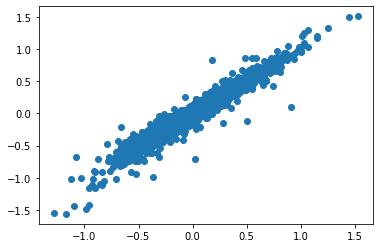

In [168]:
plt.plot(best_huberl1.predict(X_train),y_train,"o")

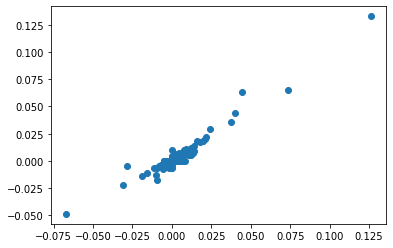

In [169]:
plt.plot(best_huberl1.coef_,best_ladl1.coef_,"o")

In [172]:
y_pred_huberl1 = np.exp(best_huberl1.predict(X_test)+y_mean)

In [173]:
# データの整形
submitPre = pd.DataFrame({
                        'Id':list(test.index),
                        'SalePrice':y_pred_huberl1
                        })
# CSV出力
submitPre.to_csv("sub_huberl1.csv",index=False)